In [2]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np


In [3]:
# Define the data directories
normal_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Normal'
hemorrhage_dir = 'C:\LMS\8\project\Medical student\CQ500_data\Processed_Hemorrhage'
# Get the list of all the images
normal_images = [os.path.join(normal_dir, img) for img in os.listdir(normal_dir)]
hemorrhage_images = [os.path.join(hemorrhage_dir, img) for img in os.listdir(hemorrhage_dir)]
# Create labels
normal_labels = [0]*len(normal_images)  # let's assume 0 for normal
hemorrhage_labels = [1]*len(hemorrhage_images)  # and 1 for hemorrhage

# Concatenate data and labels
images = normal_images + hemorrhage_images
labels = normal_labels + hemorrhage_labels


In [4]:
# Split the data into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

PyTorch uses a Dataset object, which is an abstract class representing a dataset, and a DataLoader, which wraps an iterable around the Dataset. Here's how you can create a custom Dataset for your images:

In [5]:
from torch.utils.data import Dataset
from PIL import Image
import albumentations as albu
from albumentations.pytorch import ToTensorV2

HFLIP = 'T'  # Or 'F', based on your requirement
HFLIPVAL = 1.0 if HFLIP == 'T' else 0.0

class BrainCTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            # Since albumentations requires numpy arrays, convert the image to a numpy array first
            image_np = np.array(image)
            augmented = self.transform(image=image_np)
            image = augmented['image']

        return image, label

# Transformations using albumentations
data_transforms = {
    'train': albu.Compose([
        albu.RandomResizedCrop(height=224, width=224, scale=(0.08, 1.0), ratio=(0.75, 1.3333), p=1.0),
        albu.HorizontalFlip(p=0.5),
        albu.RandomBrightnessContrast(p=0.5),
        albu.Rotate(limit=20),  # Random rotation between -20 and 20 degrees
        albu.GaussianBlur(p=0.3),
        albu.HueSaturationValue(p=0.3),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
    'val': albu.Compose([
        albu.Resize(height=256, width=256),
        albu.CenterCrop(height=224, width=224),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
    'test': albu.Compose([   # Generally, you don't augment test data. Just resize and normalize.
        albu.Resize(height=256, width=256),
        albu.CenterCrop(height=224, width=224),
        albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
        ToTensorV2()
    ]),
}

# Split the data into training, validation, and test sets
train_images, temp_images, train_labels, temp_labels = train_test_split(images, labels, test_size=0.3, random_state=42)
val_images, test_images, val_labels, test_labels = train_test_split(temp_images, temp_labels, test_size=0.5, random_state=42)

# Create the datasets
train_dataset = BrainCTDataset(train_images, train_labels, transform=data_transforms['train'])
val_dataset = BrainCTDataset(val_images, val_labels, transform=data_transforms['val'])
test_dataset = BrainCTDataset(test_images, test_labels, transform=data_transforms['test'])


# Create the dataloaders
dataloaders = {
    'train': DataLoader(train_dataset, batch_size=32, shuffle=True),
    'valid': DataLoader(val_dataset, batch_size=32, shuffle=False),
    'test': DataLoader(test_dataset, batch_size=32, shuffle=False)
}

print(f"Number of train images: {len(train_dataset)}")
print(f"Number of validation images: {len(val_dataset)}")
print(f"Number of test images: {len(test_dataset)}")


Number of train images: 4167
Number of validation images: 893
Number of test images: 893


Training Images:


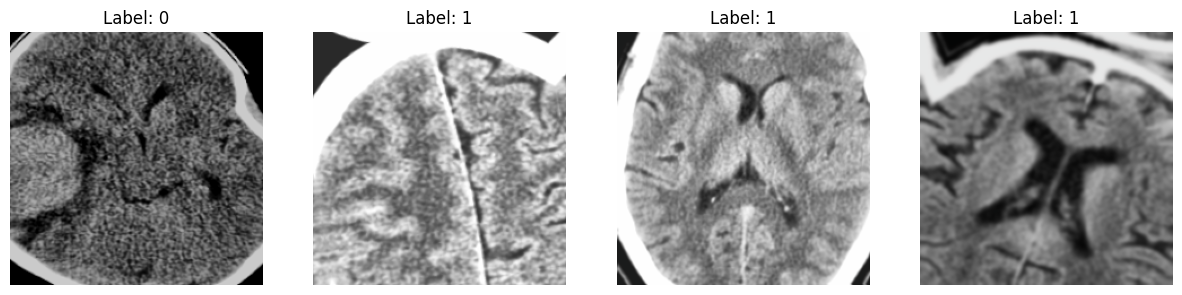

In [6]:
def visualize_random_images(dataloader, num_images=4):
    images, labels = next(iter(dataloader))
    plt.figure(figsize=(15,5))

    for index,image in enumerate(images[:num_images]):
        plt.subplot(1, num_images,index+1)
        # Unnormalize and display the image
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)
        plt.imshow(image)
        plt.title(f"Label: {labels[index].item()}")
        plt.axis("off")
    plt.show()

# Visualize random images from training dataset
print("Training Images:")
visualize_random_images(dataloaders['train'])

# # Visualize random images from validation dataset
# print("Validation Images:")
# visualize_random_images(dataloaders['valid'])

# # Visualize random images from test dataset
# print("Testing Images:")
# visualize_random_images(dataloaders['test'])


## feature extraction Densnet161


In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = models.densenet161(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model = model.to(device)
model

cuda:0


C:\Users\moheb\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\moheb\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet161_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet161_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [7]:
features_children = list(model.features.children())
truncated_features_children = features_children[:-2]
truncated_features = nn.Sequential(*truncated_features_children)
sample_input = torch.randn(1, 3, 224, 224).to(device)  
output = truncated_features(sample_input)
print(output.shape)
in_features = output.numel() // output.shape[0]  # This gives you the flattened size per sample in the batch
in_features

torch.Size([1, 1056, 7, 7])


51744

In [8]:
from collections import OrderedDict

# Replace the classifier (it will also be trainable by default)

classifier = nn.Linear(in_features, 2)  # Assuming you have 2 classes

dropout_probability = 0.2  # typically values are between 0.2 and 0.5

model = nn.Sequential(OrderedDict([
    ("features", truncated_features),
    ("flatten", nn.Flatten()),
    ("classifier", classifier)
]))

model.to(device)

Sequential(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(96, 192, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(192, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(144, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)


In [9]:
from torchinfo import summary

summary(model)

Layer (type:depth-idx)                   Param #
Sequential                               --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       (14,112)
│    └─BatchNorm2d: 2-2                  (192)
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─_DenseBlock: 2-5                  --
│    │    └─_DenseLayer: 3-1             (101,952)
│    │    └─_DenseLayer: 3-2             (111,264)
│    │    └─_DenseLayer: 3-3             (120,576)
│    │    └─_DenseLayer: 3-4             (129,888)
│    │    └─_DenseLayer: 3-5             (139,200)
│    │    └─_DenseLayer: 3-6             (148,512)
│    └─_Transition: 2-6                  --
│    │    └─BatchNorm2d: 3-7             (768)
│    │    └─ReLU: 3-8                    --
│    │    └─Conv2d: 3-9                  (73,728)
│    │    └─AvgPool2d: 3-10              --
│    └─_DenseBlock: 2-7                  --
│    │    └─_DenseLayer: 3-11            (120,576)
│   

In [10]:
import time
import copy
from tqdm.auto import tqdm

c:\Users\moheb\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10, patience=5):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_epoch = 1
    best_loss = float('inf') 
    no_improve = 0 
    early_stop = False

    history = {
        'train_loss': [],
        'valid_loss': [],
        'train_acc': [],
        'valid_acc': []
    }

    dataset_sizes = {
        'train': len(train_dataset),
        'valid': len(val_dataset),
        'test': len(test_dataset)
    }

    model.to(device)

    for epoch in tqdm(range(1, num_epochs+1)):
        epoch_start_time = time.time()

        if epoch % 10 == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs))
            print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                        
                _, preds = torch.max(outputs.detach(), 1)

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item())

            if phase == 'valid' and epoch % 10 == 0:
                print('{} Loss at epoch {}: {:.4f} Acc: {:.4f}'.format(
                    phase, epoch, epoch_loss, epoch_acc))

            if phase == 'valid':
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_acc = epoch_acc
                    best_model_wts = copy.deepcopy(model.state_dict())
                    best_epoch = epoch
                    no_improve = 0
                else:
                    no_improve += 1

                if no_improve >= patience:
                    print(f"Early stopping at epoch {epoch}. Best epoch was {best_epoch} with best valid accuracy of {best_acc:.4f}.")
                    early_stop = True
                    break
        if early_stop:
            break
        
        scheduler.step()

        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        if epoch % 10 == 0:
            print('Epoch completed in {:.0f}m {:.0f}s'.format(epoch_duration // 60, epoch_duration % 60))
            print()

    time_elapsed = time.time() - since

    if epoch % 10 == 0:
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best valid accuracy: {:4f} achieved at epoch {}'.format(best_acc, best_epoch))

    model.load_state_dict(best_model_wts)

    # Evaluate the model on test data
    model.eval()
    running_corrects = 0
    for inputs, labels in dataloaders['test']:
        inputs, labels = inputs.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    test_acc = running_corrects.double() / dataset_sizes['test']
    print('Test Accuracy: {:4f}'.format(test_acc))

    return model, history


In [19]:
# Define the criterion
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(model.classifier.parameters(), lr=0.0001,weight_decay=0.0001)

# Define the learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Train the model
model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=200, patience=10)


  4%|▍         | 9/200 [04:45<1:39:45, 31.34s/it]

Epoch 10/200
----------


  5%|▌         | 10/200 [05:16<1:39:24, 31.39s/it]

valid Loss at epoch 10: 0.5333 Acc: 0.7648
Epoch completed in 0m 32s



  8%|▊         | 15/200 [08:26<1:44:06, 33.77s/it]

Early stopping at epoch 16. Best epoch was 6 with best valid accuracy of 0.7604.


Test Accuracy: 0.745801


In [22]:
# Switch to evaluation mode
model.eval()

# Initialize the prediction and label lists
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloaders['valid']):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Compute the confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print('Confusion Matrix')
print('-'*16)
print(conf_mat)

# Compute the classification report
from sklearn.metrics import classification_report
class_report=classification_report(lbllist.numpy(), predlist.numpy())
print('Classification Report')
print('-'*20)
print(class_report)


Confusion Matrix
----------------
[[436  85]
 [129 243]]
Classification Report
--------------------
              precision    recall  f1-score   support

           0       0.77      0.84      0.80       521
           1       0.74      0.65      0.69       372

    accuracy                           0.76       893
   macro avg       0.76      0.75      0.75       893
weighted avg       0.76      0.76      0.76       893



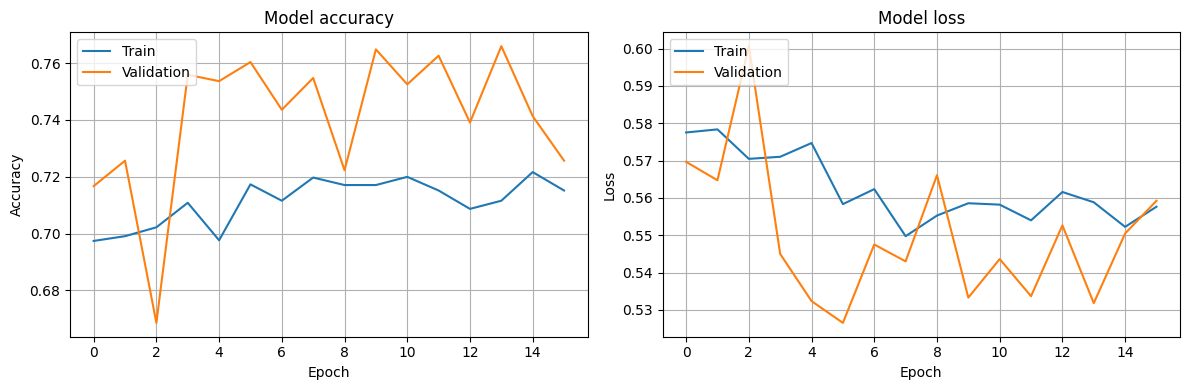

In [23]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # plot training and validation accuracy values
    ax1.plot(history['train_acc'], label='Train')
    ax1.plot(history['valid_acc'], label='Validation')
    ax1.set_title("Model accuracy")
    ax1.set(xlabel='Epoch', ylabel='Accuracy')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    # plot training and validation loss values
    ax2.plot(history['train_loss'], label='Train')
    ax2.plot(history['valid_loss'], label='Validation')
    ax2.set_title("Model loss")
    ax2.set(xlabel='Epoch', ylabel='Loss')
    ax2.legend(loc='upper left')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)

## Unfreez the whole model for fine-tuning

In [58]:
# for param in model.parameters():
#     param.requires_grad = True

In [59]:
# model, history = train_model(model, criterion, optimizer, scheduler, num_epochs=10)


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10
----------


In [29]:
# Save Model
bestmodel = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict(),
              'history': history}

torch.save(bestmodel, 'HemorrhageDensnet161_augment2_Truncate.pth')

In [2]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = False

    model.eval()

    history = checkpoint['history']  # extract the history
    return model, history  # return both the model and the history

In [30]:
model_path = 'HemorrhageDensnet_Truncate.pth'
loaded_model = load_checkpoint(model_path)

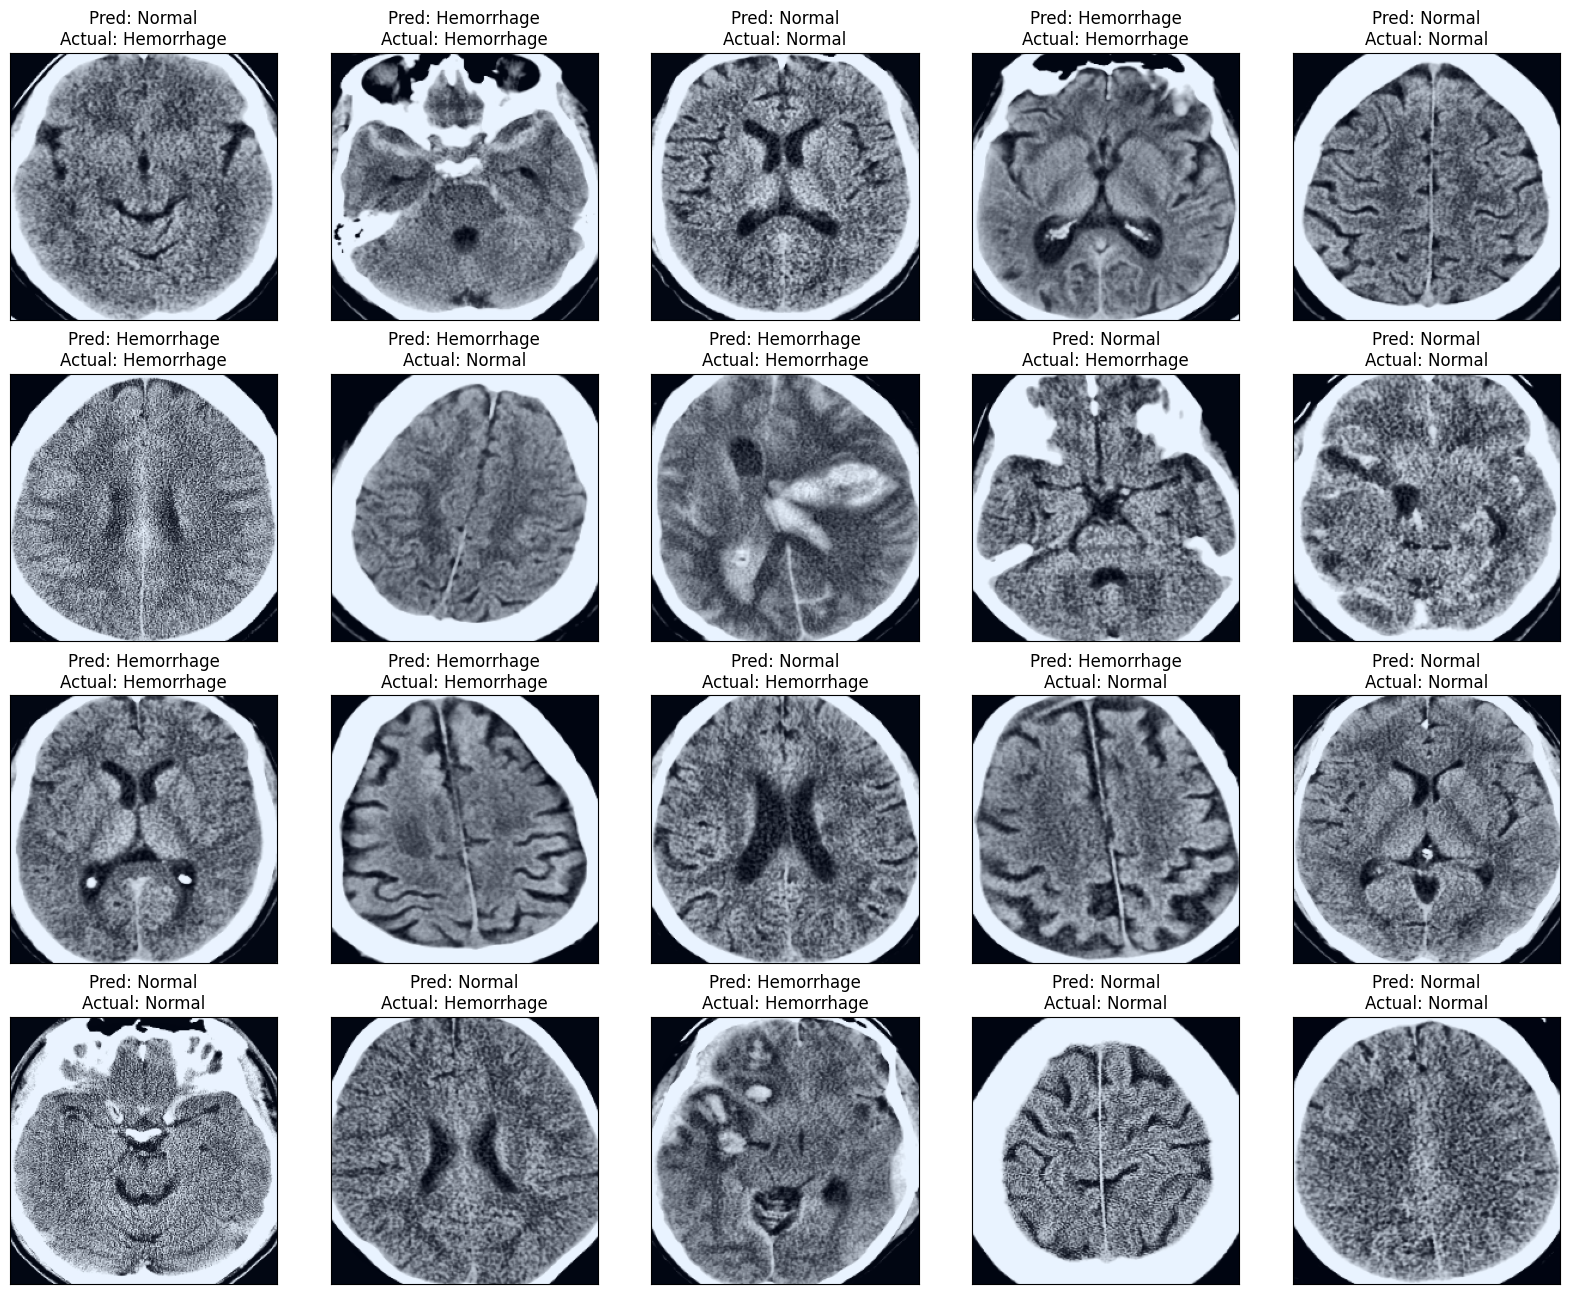

In [31]:
# Switch the model to evaluation mode
loaded_model.eval()

# Define a function to display images and predictions
def display_predictions(model, dataloader, num_images=20):
    # Ensure we have enough images to display
    assert len(dataloader.dataset) >= num_images, "Not enough samples in the dataloader."
    
    # Get batches of data until we have enough images
    images_list, labels_list = [], []
    for images, labels in dataloader:
        images_list.append(images)
        labels_list.append(labels)
        if len(images_list) * len(images_list[0]) >= num_images:
            break
    
    images = torch.cat(images_list)[:num_images]
    labels = torch.cat(labels_list)[:num_images]
    images, labels = images.to(device), labels.to(device)
    
    # Make predictions
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
    
    # Map the class indices to their respective labels
    class_names = ['Normal', 'Hemorrhage']  # Replace with your class names
    
    # Plot the images with their predictions and actual labels
    fig = plt.figure(figsize=(20, 4 * (num_images // 5)))
    for i in range(num_images):
        ax = fig.add_subplot(num_images // 5, 5, i+1, xticks=[], yticks=[])
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = (img - img.min()) / (img.max() - img.min())  # Denormalize
        ax.imshow(img)
        ax.set_title(f"Pred: {class_names[preds[i]]}\nActual: {class_names[labels[i]]}")

# Display predictions
display_predictions(loaded_model, dataloaders['valid'])


In [33]:
import cv2
import albumentations as A
import numpy as np
import matplotlib.pyplot as plt

def crop_brain(image, threshold=10):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply a binary threshold only
    _, binary = cv2.threshold(gray, threshold, 255, cv2.THRESH_BINARY)
    
    # Find the contours of the binary image
    contours, hierarchy = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Get the bounding box of the largest contour
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Crop the image using the bounding box coordinates
    crop = image[y:y+h, x:x+w]
    
    return crop

# Define the custom Albumentations transform
class BrainCrop(A.ImageOnlyTransform):
    def __init__(self, always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        
    def apply(self, image, **params):
        return crop_brain(image)

class CLAHE(A.ImageOnlyTransform):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8,8), always_apply=False, p=1.0):
        super().__init__(always_apply, p)
        self.clip_limit = clip_limit
        self.tile_grid_size = tile_grid_size
        
    def apply(self, image, **params):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        clahe = cv2.createCLAHE(clipLimit=self.clip_limit, tileGridSize=self.tile_grid_size)
        img_clahe = clahe.apply(gray)
        img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_GRAY2BGR)
        return img_clahe

# Define the transform pipeline
primal_transform = A.Compose([
    BrainCrop(),
    A.Resize(256, 256),  # Resize the cropped image
    CLAHE()  # Apply CLAHE filter
])

The predicted class for the image is: Hemorrhage
Probabilities for each class:
Normal: 1.98%
Hemorrhage: 98.02%


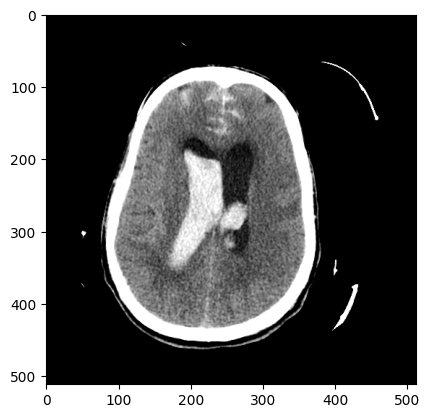

: 

In [36]:
import torch.nn.functional as F

def predict_image_class_with_probabilities(model, image_path, transform):
    """
    Predict the class of an image and return the probabilities for each class.

    Parameters:
    - model: Trained PyTorch model.
    - image_path: Path to the image file (JPG or PNG).
    - transform: Image transformations to apply before prediction.

    Returns:
    - predicted_class: Predicted class label.
    - class_probabilities: Probabilities for each class.
    """
    # Load the image
    image = Image.open(image_path).convert('RGB')
    
    # Convert the PIL image to a numpy array
    image_np = np.array(image)

    image_np = primal_transform(image=image_np)["image"]

    
    # Apply the transformations using the named argument
    augmented = transform(image=image_np)
    image_tensor = augmented['image'].unsqueeze(0).to(device)  # The 'image' key contains the transformed image tensor
    
    # Make prediction
    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        probabilities = F.softmax(output, dim=1)[0] * 100  # Convert to percentages
        _, predicted_idx = torch.max(output, 1)
    
    # Map the class indices to their respective labels
    class_names = ['Normal', 'Hemorrhage']  # Replace with your class names
    predicted_class = class_names[predicted_idx.item()]
    
    class_probabilities = {class_name: prob.item() for class_name, prob in zip(class_names, probabilities)}
    
    return predicted_class, class_probabilities

# Example usage
image_path = r"Test/CQ500CT48_slice_21.png"
image = Image.open(image_path)
plt.imshow(image)

predicted_class, class_probabilities = predict_image_class_with_probabilities(loaded_model, image_path, data_transforms['val'])
print(f"The predicted class for the image is: {predicted_class}")
print("Probabilities for each class:")
for class_name, prob in class_probabilities.items():
    print(f"{class_name}: {prob:.2f}%")
